# Likelihood based models

This notebook will outline the likelihood based approach to training on Bandit feedback.

Although before proceeding we will study the output of the simmulator in a little more detail.

In [41]:
from numpy.random.mtrand import RandomState
from reco_gym import Configuration
from agents import Agent
from sklearn.linear_model import LogisticRegression
from reco_gym import verify_agents
from agents import OrganicUserEventCounterAgent, organic_user_count_args
from reco_gym.evaluate_agent import verify_agents, plot_verify_agents



import gym, reco_gym
from copy import deepcopy
from reco_gym import env_1_args
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

ABTestNumberOfUsers=5000
NumberOfProducts=10
NumberOfSamples = 20
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=0
env_1_args['sigma_mu_organic'] = 0.0
env_1_args['sigma_omega']=0
env_1_args['random_seed'] = 42
env_1_args['num_products'] = NumberOfProducts
env_1_args['K'] = 5
env_1_args['number_of_flips'] = 5

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [42]:
data = deepcopy(env).generate_logs(ABTestNumberOfUsers)

# Logistic Regression Model

## Turn Data into Features

Now we are going to build a _Logistic Regression_ model.

The model will predict _the probability of the click_ for the following data:
* _`Views`_ is a total amount of views of a particular _`Product`_ shown during _Organic_ _`Events`_ **before** a _Bandit_ _`Event`_.
* _`Action`_ is a proposed _`Product`_ at a _Bandit_ _`Event`_.

For example, assume that we have _`10`_ products. In _Organic_ _`Events`_, these products  were shown to a user as follows:
<table>
    <tr>
        <th>Product ID</th>
        <th>Views</th>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>1</td>
        <td>0</td>
    </tr>
    <tr>
        <td>2</td>
        <td>0</td>
    </tr>
    <tr>
        <td>3</td>
        <td>7</td>
    </tr>
    <tr>
        <td>4</td>
        <td>0</td>
    </tr>
    <tr>
        <td>5</td>
        <td>0</td>
    </tr>
    <tr>
        <td>6</td>
        <td>0</td>
    </tr>
    <tr>
        <td>7</td>
        <td>8</td>
    </tr>
    <tr>
        <td>8</td>
        <td>11</td>
    </tr>
    <tr>
        <td>9</td>
        <td>0</td>
    </tr>
</table>

When we want to know the probability of the click for _`Product`_ = _`8`_ with available amounts of _`Views`_, the input data for the model will be:

_`0 0 0 7 0 0 0 0 8 11 0`_ _**`8`**_

The first 10 numbers are _`Views`_ of _`Products`_ (see above), the latest one is the _`Action`_.

The output will be two numbers:
* $0^{th}$ index: $1 - \mathbb{P}_c(P=p|V)$.
* $1^{st}$ index: $\mathbb{P}_c(P=p|V)$.

Here, $\mathbb{P}_c(P=p|V)$ is the probability of the click for a _`Product`_ $p$, provided that we have _`Views`_ $V$.


In all following models, an _`Action`_ will not be used as a number, but it will be decoded as a _vector_.
In our current example, the _`Action`_ is _`8`_. Thus, it is encoded as:

_`0 0 0 0 0 0 0 0`_ _**`1`**_ _`0`_

Here,
* Vector of _`Actions`_ has a size that is equal to the _*number of `Products`*_ i.e. _`10`_.
* _`Action`_ _`8`_ is marked as _`1`_ (_`Action`_ starts with _`0`_).

In [43]:
import math
import numpy as np

def build_train_data(data):
    """
    Build Train Data

        Parameters:
            data: offline experiment logs
                the data contains both Organic and Bandit Events

        Returns:
            :(features, outs)
    """
    num_products = int(data.v.max() + 1)
    number_of_users = int(data.u.max()) + 1

    history = []
    actions = []
    outs = []

    for user_id in range(number_of_users):
        views = np.zeros((0, num_products))
        for _, user_datum in data[data['u'] == user_id].iterrows():
            if user_datum['z'] == 'organic':
                assert (math.isnan(user_datum['a']))
                assert (math.isnan(user_datum['c']))
                assert (not math.isnan(user_datum['v']))

                view = int(user_datum['v'])

                tmp_view = np.zeros(num_products)

                tmp_view[view] = 1

                # Append the latest view at the beginning of all views.
                views = np.append(tmp_view[np.newaxis, :], views, axis = 0)
            else:
                assert (user_datum['z'] == 'bandit')
                assert (not math.isnan(user_datum['a']))
                assert (not math.isnan(user_datum['c']))
                assert (math.isnan(user_datum['v']))

                action = int(user_datum['a'])
                action_flags = np.zeros(num_products, dtype = np.int8)
                action_flags[int(action)] = 1

                click = int(user_datum['c'])

                history.append(views.sum(0))
                actions.append(action_flags)
                outs.append(click)

    return np.array(outs), history, actions

In [ ]:
clicks, history, actions = build_train_data(data)

In [66]:
data[0:27]

,a,c,ps,ps-a,t,u,v,z
0,NaN,NaN,NaN,None,0,0,0.0,organic
1,3.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1,0,NaN,bandit
2,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",2,0,NaN,bandit
3,5.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",3,0,NaN,bandit
4,NaN,NaN,NaN,None,0,1,1.0,organic
5,2.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1,1,NaN,bandit
6,8.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",2,1,NaN,bandit
7,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",3,1,NaN,bandit
8,NaN,NaN,NaN,None,4,1,6.0,organic
9,NaN,NaN,NaN,None,5,1,6.0,organic


In [63]:
history[0:8]

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 6., 2., 0., 2., 0., 9., 0., 0., 0.]),
 array([0., 6., 2., 0., 2., 0., 9., 0., 0., 0.])]

In [64]:
actions[0:8]

[array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int8),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int8),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int8),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)]

Look at the data and see how it maps into the features - which is the combination of the history and the actions and the label which is clicks.  Note that only the bandit events correspond to records in the training data.

In order to do personalisation it is necessary to cross the action and history features. _Why_?  We do the simplest possible cross an element wise kronecker product.


In [56]:
from agents import FeatureProvider
import pdb

class CrossFeatureProvider(FeatureProvider):
    """Feature provider as an abstract class that defined interface of setting/getting features"""

    def __init__(self, config):
        super(CrossFeatureProvider, self).__init__(config)
        self.feature_data = None

    def observe(self, observation):
        """Consider an Organic Event for a particular user"""
        for session in observation.sessions():
            self.feature_data[session['v']] += 1

    def features(self, observation):
        """Provide feature values adjusted to a particular feature set"""
        return self.feature_data

    def reset(self):
        self.feature_data = np.zeros((self.config.num_products))


class ModelBasedAgent(Agent):
    def __init__(self, env, feature_provider, model):
        # Set environment as an attribute of Agent.
        self.env = env
        self.feature_provider = feature_provider
        self.model = model
        self.reset()

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past history"""
        self.feature_provider.observe(observation)
        cross_features = np.kron(np.eye(10),self.feature_provider.features(observation))
        prob = self.model.predict_proba(cross_features)[:, 1]
        action = np.argmax(prob)
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            }
        }

    def reset(self):
        self.feature_provider.reset()

In [57]:
def build_history_agent(env_args, data):
    outs, history, actions = build_train_data(data)
    features = np.vstack([np.kron(aa,hh) for hh, aa in zip(history, actions)])

    config = Configuration(env_args)
    logreg = LogisticRegression(
        solver = 'lbfgs',
        max_iter = 5000,
        random_state = config.random_seed
    )

    log_reg_fit = logreg.fit(features, outs)

    return ModelBasedAgent(
        config,
        CrossFeatureProvider(config),
        log_reg_fit
    )



In [47]:
likelihood_logreg =  build_history_agent(env_1_args, data)

In [48]:
organic_counter_agent = OrganicUserEventCounterAgent(Configuration({
            **organic_user_count_args,
            **env_1_args,
            'select_randomly': True,
        }))

In [54]:
result = verify_agents(env, 5000, {'likelihood logreg': likelihood_logreg, 'organic count': organic_counter_agent})

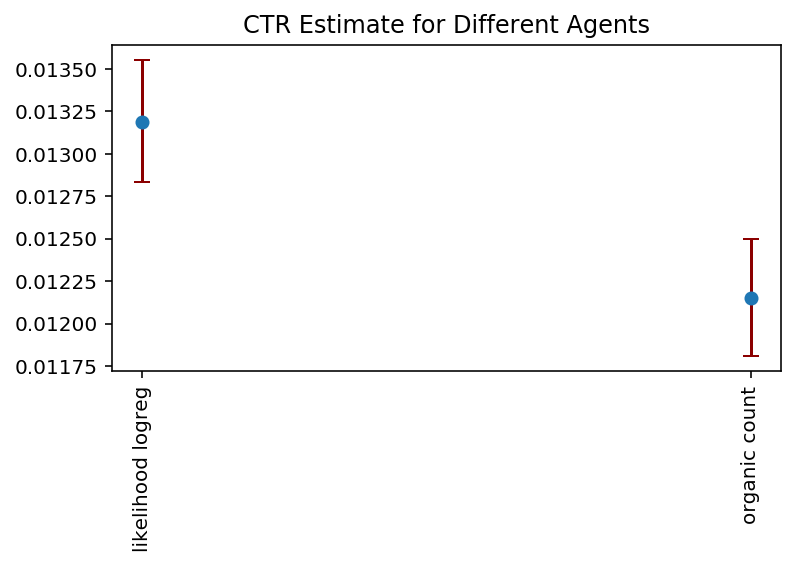

In [55]:
fig = plot_verify_agents(result)
plt.show()